# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


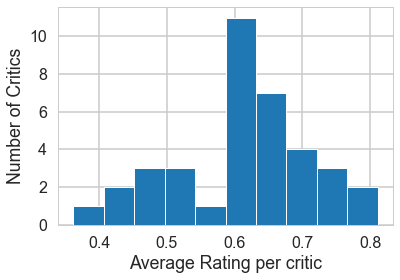

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

The histogram above shows how tenured critics (over 100 reviews) give ratings. "Average Rating per critic" can more naturally be though of as - percent of the time the critic gives a fresh rating. It appears that critics tend to prefer giving fresh ratings or even that they intentially try to lean toward more positive reviews than negative - nearly half the critics give a fresh rating 60 to 70 percent of the time, while only 3 critics do so between 50 and 60 percent of the time. More importantly, it shows that either tenured critics prefer to see good movies (let the intern cover John Carter 2) OR that critics' ratings are not based on how a movie compares to other movies - since their average ratings are... above average.

The shape of the distribution is somewhat Gaussian but with a negative skew. It's hard to say that for sure, or to draw any strong conclusions since there are so few critics being considered.

In [7]:
print('Number of critics with over 100 reviews:',(counts > 100).sum())

Number of critics with over 100 reviews: 37


These initial observations cannot be taken with great certainty, but there are three potential explanations for the shape of the distribution:
1. Tenured critics self-police, ensuring that for every bad review they write at least one good review.
2. Tenured critics get to review mostly good movies.
3. Tenured critics are tenured critics **because** they give better reviews.

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [17]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [25]:
#your turn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# 1.
X_train, X_test, y_train, y_test = train_test_split(X, y)

# 2 & 3.
mnb = MultinomialNB().fit(X_train, y_train)

# .4
print('Training accuracy: {:.3f}\nTesting accuracy: {:.3f}'.format(mnb.score(X_train,y_train), mnb.score(X_test,y_test)))

Training accuracy: 0.922
Testing accuracy: 0.771


This is pretty good for an out-of-the-box classifier - meaning, in just 3 lines of code without any parameter tuning or feature transformations it was able to correctly classify ratings 77% of the time. That said, there is definitely room for improvement, most notably in the way the classifier severely overfits the training data (92% accuracy compared to 77%).

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

CDF cut at x = 100.
The 315 most used words span from 101 to 9502 documents despite making up 1.405 percent of the vocabulary.


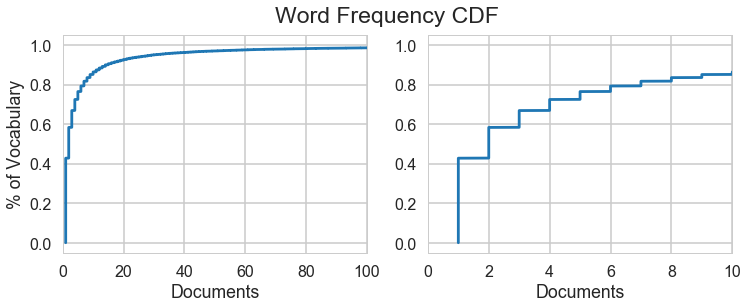

In [190]:
# get a word matrix with words as features and docs as obs,
# mark cell(i,j) as 1 if word j appears in doc i, else 0.
X_bin = CountVectorizer(binary=True).fit_transform(critics.quote)

# sum each column to get the total docs each word appears in,
# then do some numpy wrangling to get it in shape
freqs = sorted(np.asarray(X_bin.sum(axis=0))[0].T)

# get y values to move up in incremental percentages of total words
# while the x values reflect the document counts of each word and have
# been sorted
n = len(freqs)
cdf = np.arange(n)/n

# make a pretty picture - limit x axis because after around 100
# the document counts start to get very spread out.
fig = plt.figure(figsize = (12,4))
fig.suptitle('Word Frequency CDF')
ax = fig.add_subplot(121)
ax.plot(sorted_df,yvals)

ax.set_xlabel('Documents')
ax.set_ylabel('% of Vocabulary')
ax.set_xlim([0,100])

# make another pretty picture with a close-up
ay = fig.add_subplot(122)
ay.plot(sorted_df,yvals)
ay.set_xlabel('Documents')
ay.set_xlim([0,10])

# confirm how spread out the document counts are at the higher levels
# these are probably words like 'the', 'a', etc.
print('CDF cut at x = 100.\nThe 315 most used words span from', freqs[-315], 'to', freqs[-1],'documents despite making up',
      round(100*315/n,3), 'percent of the vocabulary.')

**Exercise Answers:**
A good value for min_df is probably 2 - meaning nearly 60% of the words appear in 2 documents or less.  Since this study isn't addressing synonyms or NLP, there's nothing that can really be done with those words other than to assume they are unusual/rare and unrelatable to other features.

max_df is more difficult to gauge. These are going be things like 'the', 'a', 'movie'. You could argue anywhere from 30 to 100 really. A higher max_df will filter out more common, irrelevant words BUT the classifier relies on commonality between features for prediction, so you don't want to filter out too many. I'll say 100, since as pointed out earlier, you're only losing about 1.4% of the vocabulary.

**Note:** This is technically cheating. Since we're looking at the CDF of all the data, we are gaining insights into the test data and using those insights to trim out noise that will lead to a better fit. This may make our model less generalizable on new test data.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [191]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [192]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [193]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

#### Answer part 1:
The log_liklihood function first uses the predict_log_proba() method on the feature space (without target values) to come up with a matrix of probabilities for all documents indicating both how likely they are to be rotten and how likely they are to be fresh. All those calculations are based on how the classifier was previously trained.

The function then uses the target values as indices on each column of the matrix and adds everything up. Since only the probabilities from entries reflecting the actual class in the target values will make it into the sum, the value will be at its highest when the probabilities associated with the correct class for each document are at their highest.

The classifier is being trained with data not seen in the scoring function as well as a hyperparameter $\alpha$ which acts both as a regularization penalty (since it decreases the more probability for words that were seen more often) and a prevention against probabilities of 0 in the $\prod P$.

It is also worth noting, that even though this scoring measure doesn't directly consider false-positive rate, it is also being minimized, since the probabilities for each document must sum nearly to 1 (pesky $\alpha$. However this measure is looking at the log of the probabilities (to avoid underflow from dealing with extremely small numbers) - and while these log probabilities do not sum to one, they remain inversely proportional to one another.

#### Answer part 2:

If $\alpha$ was very large it would drown out the $N_{ic}$ and $N_c$ in the probability calculation, leaving only $N_i$ to influence it. Each word's probability would therefore become inversely proportional to its global frequency in the documents regardless of class association, and in the subsequent calculations each class would have an equal probability for every document.

#### Answer part 3:

Before going into the code, there appears to be an error with the code that was provided by the notebook. `mask` was created using the test indices instead of the training ones. Training data is meant to be 70%, but...

In [201]:
mask.sum()/len(mask)

0.30004498425551057

So I have made slight changes to the code that was provided below, using `~mask` instead of `mask`.

In [216]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 2 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[~mask] # FIXED!
    ytrainthis = ythis[~mask] # FIXED!
    # your turn
    clf = MultinomialNB(alpha=alpha)
    score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
    if score > maxscore:
        best_alpha = alpha
        maxscore = score

In [213]:
print("alpha: {}".format(best_alpha))

alpha: 1


### Before Moving On...

I think there's another problem with that exercise. **Why** does it build the verctorizer and Xthis ythis each iteration despite nothing changing? This doesn't really matter on this problem because the data being handled is small enough that time and space are cheap, but it's still kind of sloppy.

<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [217]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
# CORRECTING THESE AS BEFORE
xtrain=X[~mask]
ytrain=y[~mask]
xtest=X[mask]
ytest=y[mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.902497
Accuracy on test data:     0.765474


In [218]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[1240  620]
 [ 475 2334]]


Sadly, it doesn't appear that this classifier is any better than the out-of-the-box version. Accuracy went down both on training and testing (marginally). Maybe it's better than the first one because the testing accuracy stayed about the same but the training accuracy went down, so it's more generalizeable and will perform better on unseen data. But there's not much difference.

Looking at the confusion matrix it's clear the problem lies more with picking which movies were rated fresh than which were rated rotten (good true-negative rate, mediocre true-positive rate).

It's also worth noting that the default value for $\alpha$ in MultinomialNB is the same as `best_alpha`, so the only difference between this classifier and the original is the min_df argument in the vectorization.

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [219]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
             delight 0.97
            captures 0.96
           childhood 0.96
            touching 0.95
          engrossing 0.95
                myth 0.95
            hypnotic 0.95
              tender 0.95
            intimate 0.95
              wilder 0.95
Bad words	     P(fresh | word)
             unfunny 0.09
            sluggish 0.09
             trailer 0.09
       unfortunately 0.08
     disappointingly 0.07
             witless 0.07
           misguided 0.06
          uninspired 0.05
           pointless 0.05
                lame 0.04


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

The probability of each row represents the probability that a movie was rated fresh given the presence of that word in the review.

This works because the classifier was previously trained on all the words and is now being given an identity matrix of the words (each row and column has only 1 non-zero value for each word in the vectorization). Because the predict_log_proba method involves a dot product of the words in the record it was given with the prior probabilities, everything becomes 0 except for the probability associated with that one specific word.

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [222]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
As a depiction of a loving-turbulent relationship between a single mom (Susan Sarandon) and her rebellious teenage daughter (Natalie Portman), Wang's meller is nicely crafted but old-fashioned like Hollywood's weepies of yesteryear.

It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

Lauded as a witty moral fable with a revelatory performance from its star, this romantic comedy is in fact meretricious, manipulative and reactionary.

Working from an Elmore Leonard novel, Tarantino has created a gangster fiction that is never larger than life and sometimes smaller.

Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pur

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [227]:
#your turn
review = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
clf.predict_proba(review)

array([[  8.41604205e-04,   9.99158396e-01]])

The classifier thinks there's a 99.9% chance that this movie got a fresh review.

From having read the previous misses, this actually is what I'd except the classifier to do (though obviously don't **want** it to). The classifier works based on the frequency of words associated with fresh ratings, it doesn't know how to interpret order or coeffects. Basically, the classifier doesn't understand that the word *not* is modifying the adjectives, it only knows that wherever it's seen 'remarkable', 'touching', and 'superb' has been in fresh rated reviews.

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [228]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

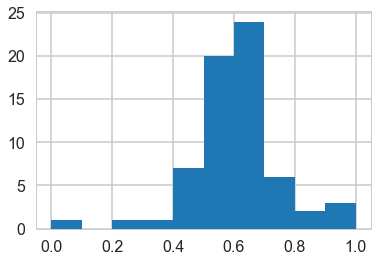

In [237]:
# Your turn
critics['bin_fresh'] = critics.fresh == 'fresh'
pub_weight = critics.groupby('publication').bin_fresh.agg(['mean', 'count'])
pub_weight['mean'].hist()
plt.show()

Just as more tenured critics tended to give higher ratings, certain publications also tend to give higher ratings. I'll use their average rating as a weight for the predicted probabilities. To keep from overfitting, I'll filter out all publications that don't have very many reviews and give them all weight 1 so their probabilities are not impacted.

In [251]:
 pub_weight.loc[pub_weight['count'] <=10, 'mean'] = .5
critics['avg_score'] = critics.publication.map(pub_weight['mean'])
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title,bin_fresh,avg_score
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story,True,0.650960
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story,True,0.735751
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story,True,0.780822
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story,True,0.668081
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story,True,0.584148


### Add TF-IDF Vectorizer & Better Tuning

I'll tune as before on alpha, but also add a min_df and max_df tuner.

In [253]:
#the grid of parameters to search over
alphas = [.1,.25,.5, 1, 2.5, 5, 7.5, 10]
mindfs = [0,1,2,3,4]
maxdfs = [.5,.6,.7,.8,.9]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_mindf = None
best_maxdf = None
maxscore=-np.inf
for alpha in alphas:
    for mindf in mindfs:
        for maxdf in maxdfs:
            vectorizer = TfidfVectorizer(min_df=mindf, stop_words='english', max_df=maxdf)
            Xthis, ythis = make_xy(critics, vectorizer)
            Xtrainthis = Xthis[~mask] # FIXED!
            ytrainthis = ythis[~mask] # FIXED!
            clf = MultinomialNB(alpha=alpha)
            score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
            if score > maxscore:
                best_mindf = mindf
                best_maxdf = maxdf
                best_alpha = alpha
                maxscore = score

In [254]:
print('Best Params:\nalpha: {}\nmin_df: {}\nmax_df {}'.format(best_alpha, best_mindf, best_maxdf))

Best Params:
alpha: 0.25
min_df: 4
max_df 0.5


In [266]:
def check_results(best_alpha, best_mindf, best_maxdf, tfid = True):
    if tfid:
        vectorizer = TfidfVectorizer(min_df=best_mindf, max_df=best_maxdf)
    else:
        vectorizer = CountVectorizer(min_df=best_mindf, max_df=best_maxdf)
    X, y = make_xy(critics, vectorizer)
    # CORRECTING THESE AS BEFORE
    xtrain=X[~mask]
    ytrain=y[~mask]
    xtest=X[mask]
    ytest=y[mask]
    clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)
    training_accuracy = clf.score(xtrain, ytrain)
    test_accuracy = clf.score(xtest, ytest)
    print("Accuracy on training data: {:2f}".format(training_accuracy))
    print("Accuracy on test data:     {:2f}".format(test_accuracy))

In [262]:
check_results(best_alpha, best_mindf, best_maxdf)

Accuracy on training data: 0.882850
Accuracy on test data:     0.753052


## Results...
The accuracy actually went down on both training and testing. As a fictional TV critic once said, *It stinks!*

Small glimmer of hope... the best parameters for min and max df were both edges, so let's try expanding the seach in those directions.

In [256]:
#the grid of parameters to search over
alphas = [.1,.2,.25,.3, 1, 2.5]
mindfs = [4,5,6,7,8]
maxdfs = [.2,.3,.4,.5]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_mindf = None
best_maxdf = None
maxscore=-np.inf
for alpha in alphas:
    for mindf in mindfs:
        for maxdf in maxdfs:
            vectorizer = TfidfVectorizer(min_df=mindf, stop_words='english', max_df=maxdf)
            Xthis, ythis = make_xy(critics, vectorizer)
            Xtrainthis = Xthis[~mask] # FIXED!
            ytrainthis = ythis[~mask] # FIXED!
            clf = MultinomialNB(alpha=alpha)
            score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
            if score > maxscore:
                best_mindf = mindf
                best_maxdf = maxdf
                best_alpha = alpha
                maxscore = score

In [257]:
print('Best Params:\nalpha: {}\nmin_df: {}\nmax_df {}'.format(best_alpha, best_mindf, best_maxdf))

Best Params:
alpha: 0.3
min_df: 4
max_df 0.2


#### Next results
Still getting edge parameters. Let's try again. Sorry for the wall of text, I'll functionalize from here on.

In [265]:
def tune_params(alphas, mindfs, maxdfs, tfid=True):
    best_alpha = None
    best_mindf = None
    best_maxdf = None
    maxscore=-np.inf
    for alpha in alphas:
        for mindf in mindfs:
            for maxdf in maxdfs:
                if tfid:
                    vectorizer = TfidfVectorizer(min_df=mindf, stop_words='english', max_df=maxdf)
                else:
                    vectorizer = CountVectorizer(min_df=mindf, max_df=maxdf)
                Xthis, ythis = make_xy(critics, vectorizer)
                Xtrainthis = Xthis[~mask] # FIXED!
                ytrainthis = ythis[~mask] # FIXED!
                clf = MultinomialNB(alpha=alpha)
                score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
                if score > maxscore:
                    best_mindf = mindf
                    best_maxdf = maxdf
                    best_alpha = alpha
                    maxscore = score
    print('Best Params:\nalpha: {}\nmin_df: {}\nmax_df {}'.format(best_alpha, best_mindf, best_maxdf))
    return best_alpha, best_mindf, best_maxdf

In [263]:
alphas = [.25,.3, .35, .4, 1]
mindfs = [2,3,4,5,6]
maxdfs = [.1,.2,.3]
best_alpha, best_mindf, best_maxdf = tune_params(alphas, mindfs, maxdfs)

Best Params:
alpha: 0.3
min_df: 4
max_df 0.2


In [264]:
check_results(best_alpha, best_mindf, best_maxdf)

Accuracy on training data: 0.882850
Accuracy on test data:     0.753052


## Zilch.
No improvement even with params not on edges. Maybe it's the tf-idf vectorizer that stinks for this problem? I'll try tuning with the count vectorizer.

In [267]:
alphas = [.25,.3, .35, .4, 1]
mindfs = [2,3,4,5,6]
maxdfs = [.1,.2,.3]
best_alpha, best_mindf, best_maxdf = tune_params(alphas, mindfs, maxdfs, tfid = False)

Best Params:
alpha: 1
min_df: 6
max_df 0.1


In [270]:
alphas = [.4, .8, 1, 1.2, 2]
mindfs = [5,6,7,8]
maxdfs = [.05,.1,.2]
best_alpha, best_mindf, best_maxdf = tune_params(alphas, mindfs, maxdfs, tfid = False)

Best Params:
alpha: 2
min_df: 5
max_df 0.05


In [274]:
alphas = [3,3.5,4,5]
mindfs = [5,6,7,8,9]
maxdfs = [.03,.05,.1]
best_alpha, best_mindf, best_maxdf = tune_params(alphas, mindfs, maxdfs, tfid = False)

Best Params:
alpha: 5
min_df: 8
max_df 0.05


In [275]:
alphas = [4,5,7.5,10]
mindfs = [7,8,9]
maxdfs = [.03,.04,.05,.06]
best_alpha, best_mindf, best_maxdf = tune_params(alphas, mindfs, maxdfs, tfid = False)

Best Params:
alpha: 5
min_df: 8
max_df 0.05


In [276]:
check_results(best_alpha, best_mindf, best_maxdf, tfid = False)

Accuracy on training data: 0.831711
Accuracy on test data:     0.749839


## Moving On!

The parameters converged but they didn't seem to help the accuracy. Log liklihood is probably not the best scoring metric for measuring their performance.

Let's see if the publication weight makes a difference.

Below I fit a classifier on the training data, and attach the probability predictions for fresh onto the critics dataframe. Then I make a few functions to play around with weights when adding to or multiplying the predicted probability by the fresh percentage of the publication's reviews.

In [277]:
tf_vectorizer = TfidfVectorizer(min_df=best_mindf, max_df=best_maxdf)
vectorizer = CountVectorizer(min_df=best_mindf, max_df=best_maxdf)
X, y = make_xy(critics, vectorizer)
tfX, tfy = make_xy(critics, tf_vectorizer)

In [284]:
xtrain=X[~mask]
ytrain=y[~mask]
xtest=X[mask]
ytest=y[mask]

tf_xtrain=tfX[~mask]
tf_ytrain=tfy[~mask]
tf_xtest=tfX[mask]
tf_ytest=tfy[mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)
tf_clf = MultinomialNB(alpha=best_alpha).fit(tf_xtrain, tf_ytrain)

In [367]:
prob_fresh = pd.Series(list(clf.predict_proba(X)[:,1]), index = critics.index)
tf_prob_fresh = pd.Series(list(clf.predict_proba(tfX)[:,1]), index = critics.index)
# prob_fresh = 1- np.exp(prob_fresh)
# tf_prob_fresh = 1- np.exp(tf_prob_fresh)

critics['prob_fresh'] = prob_fresh
critics['tf_prob_fresh'] = tf_prob_fresh
critics.bin_fresh = critics.bin_fresh.astype(int)

In [359]:
def play_with_weight(df, w, idx):
    df['weight_score'] = w*df.prob_fresh + (1-w)*df.avg_score
    df['predict'] = 0
    df.loc[df['weight_score'] >= .5, 'predict'] = 1
    df['correct'] = df['predict'] == df['bin_fresh']
    df = df[idx]
    return df['correct'].mean()

In [362]:
for w in [.5,.6,.7,.8,.9,1]:
    print('At weight', w,'prediction is',round(100*play_with_weight(critics, w, mask),3), '% accurate.')

At weight 0.5 prediction is 74.127 % accurate.
At weight 0.6 prediction is 74.534 % accurate.
At weight 0.7 prediction is 74.641 % accurate.
At weight 0.8 prediction is 74.727 % accurate.
At weight 0.9 prediction is 74.791 % accurate.
At weight 1 prediction is 74.984 % accurate.


In [363]:
def play_by_weight(df, w, idx):
    df['weight_score'] = df.prob_fresh*(df.avg_score + w)
    df['predict'] = 0
    df.loc[df['weight_score'] >= .5, 'predict'] = 1
    df['correct'] = df['predict'] == df['bin_fresh']
    df = df[idx]
    return df['correct'].mean()

In [366]:
for w in [.1,.2,.3,.4]:
    print('At weight', w,'prediction is',round(100*play_by_weight(critics, w, mask),3), '% accurate.')

At weight 0.1 prediction is 73.42 % accurate.
At weight 0.2 prediction is 75.691 % accurate.
At weight 0.3 prediction is 75.926 % accurate.
At weight 0.4 prediction is 75.305 % accurate.


# Final Results
Dissappointing. None of the parameter tuning or feature inclusion seemed to make a bit of difference. I got the accuracy up to almost 76% which... is lower than the out-of-the-box classifier performed. Definitely suggests log likelihood is a bad score function for tuning the parameters.